In [1]:
import warnings
from typing import Optional
warnings.filterwarnings('ignore')

import numpy as np
from tqdm import tqdm
import pandas as pd
from pandas import DataFrame
from obp.ope import RegressionModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import check_random_state

from dataset.synthetic import SyntheticBanditDatasetWithCluster
from ope.regression import PairWiseRegression
from ope.estimator import InversePropensityScore as IPS
from ope.estimator import OFFCEM
from policy.policylearners import PolicyLearnerOverActionSpaces
from policy.policylearners import PolicyLearnerOverClusterSpaces
from policy.policylearners import RegBasedPolicyLearner
from policy.nn_model import MultiLayerPerceptron as MLP
from policy.nn_model import TwoTowerModel as TTM
from utils.common import visualize_learning_curve

In [2]:
# setting
n_users=30
dim_context=10
n_actions=300
n_cat_per_dim=10
n_cat_dim=5
n_clusters=10
beta=-0.5
reward_noise=1.0
random_state=12345
n_sim=30
val_size=1000
test_size=1000
batch_size=512
hidden_layer_size=(30, 30, 30)
max_iter=30

In [3]:
def train_reward_model_via_two_stage(
    val_data: dict,
    test_data: dict,
    true_dist_dict: Optional[dict] = None
) -> tuple[np.ndarray, ...]:
    
    if true_dist_dict is not None:
        # skip estimation in advance
        val_data["n_learned_clusters"] = val_data["n_true_clusters"] 
        val_data["cluster"] = val_data["true_cluster"]
        val_data["phi_x_a"] = val_data["true_phi_x_a"]
        test_data["n_learned_clusters"] = test_data["n_true_clusters"] 
        test_data["cluster"] = test_data["true_cluster"]
        test_data["phi_x_a"] = test_data["true_phi_x_a"]
        
        
        random_ = check_random_state(None)
        
        q_hat = random_.normal(true_dist_dict["q_x_a"], scale=1.)
        
        phi_x_a = val_data["phi_x_a"]
        h_hat = random_.normal(true_dist_dict["h_x_a"], scale=1.)
        g_hat = random_.normal(true_dist_dict["g_x_c"], scale=1.)
        f_hat = h_hat + g_hat[np.arange(val_data["n_users"])[:, None], true_dist_dict["phi_x_a"]]
        
        
        return q_hat, f_hat
    
    dim_context, n_actions, n_clusters = val_data["context"].shape[1], val_data["n_actions"], val_data["n_learned_clusters"]
    
    ## train_reward_via_two_stage
    ### 1st-stage
    pairwise_model = PairWiseRegression(
        dim_context=dim_context,
        n_actions=n_actions,
        n_clusters=n_clusters,
        batch_size=256,
        hidden_layer_size=(10, 10, 10),
        learning_rate_init=0.1,
        max_iter=30,
        #verbose=True
    )

    pairwise_model.fit(bandit_data=val_data)
    h_hat = pairwise_model.predict(context=val_data["x_u"])
    
    ### 2nd-stage
    val_size = val_data["n_rounds"]
    reward = val_data["reward"]
    reward_residual = reward - h_hat[val_data["user_idx"], val_data["action"]]
    cluster = val_data["cluster"]
    reg_model = RegressionModel(
        n_actions=n_clusters,
        action_context=np.eye(n_clusters),
        base_model=RandomForestRegressor(n_estimators=30, max_depth=30)
    )

    reg_model.fit(
        context=val_data["context"],
        action=cluster,
        reward=reward_residual
    )
    g_hat = reg_model.predict(val_data["x_u"])[:, :, 0]

    phi_x_a = val_data["phi_x_a"]
    f_hat = h_hat + g_hat[np.arange(val_data["n_users"])[:, None], phi_x_a]

    
    ## one-step reward regression
    reg_model = RegressionModel(
        n_actions=n_actions,
        action_context=val_data["action_context_one_hot"],
        base_model=RandomForestRegressor(n_estimators=30, max_depth=30)
    )
    reg_model.fit(
        context=val_data["context"],
        action=val_data["action"],
        reward=val_data["reward"],
    )
    q_hat = reg_model.predict(val_data["x_u"])[:, :, 0]
    
    return q_hat, f_hat
    

In [4]:
dataset = SyntheticBanditDatasetWithCluster(
    n_users=n_users,
    dim_context=dim_context,
    n_actions=n_actions,
    n_cat_per_dim=n_cat_per_dim,
    n_cat_dim=n_cat_dim,
    n_clusters=n_clusters,
    beta=beta,
    reward_noise=reward_noise,
    random_state=random_state
)
true_dist_dict = dataset.true_dist_dict
pi_b_a_x = true_dist_dict["pi_0_a_x"]
pi_b_value = dataset.calc_ground_truth_policy_value(pi_b_a_x)

dim_action_context = dataset.action_context_one_hot.shape[1]

curve_df = DataFrame()
for _ in tqdm(range(n_sim)):
    val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
    test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_size)
    
    q_hat, f_hat = train_reward_model_via_two_stage(val_data, test_data)
    
    # Reg-based(simple MLP)
    nn_model = MLP(dim_context=dim_context, dim_output=n_actions, objective="regression", hidden_layer_size=hidden_layer_size)
    reg = RegBasedPolicyLearner(
        nn_model=nn_model,
        max_iter=max_iter,
        learning_rate_init=0.01,
        batch_size=batch_size,
        ope_estimator=IPS(estimator_name="IPS")
    )
    reg.fit(val_data, test_data, true_dist_dict=true_dist_dict)
    reg_ = DataFrame([reg.test_value, ["Reg-based"] * max_iter], index=["value", "method"]).T.reset_index()
    
    # IPS-PG
    nn_model = MLP(dim_context=dim_context, dim_output=n_actions, objective="decision-making", hidden_layer_size=hidden_layer_size)
    ips = PolicyLearnerOverActionSpaces(
        nn_model=nn_model,
        max_iter=max_iter,
        learning_rate_init=0.01,
        batch_size=batch_size,
        ope_estimator=IPS(estimator_name="IPS")
    )
    ips.fit(val_data, test_data, true_dist_dict=true_dist_dict)
    ips_ = DataFrame([ips.test_value, ["IPS-PG"] * max_iter], index=["value", "method"]).T.reset_index()
    
    # DR-PG
    nn_model = MLP(dim_context=dim_context, dim_output=n_actions, objective="decision-making", hidden_layer_size=hidden_layer_size)
    dr = PolicyLearnerOverActionSpaces(
        nn_model=nn_model,
        max_iter=max_iter,
        learning_rate_init=0.01,
        batch_size=batch_size,
        ope_estimator=IPS(estimator_name="IPS")
    )
    
    dr.fit(val_data, test_data, q_hat=q_hat[val_data["user_idx"]], true_dist_dict=true_dist_dict)
    dr_ = DataFrame([dr.test_value, ["DR-PG"] * max_iter], index=["value", "method"]).T.reset_index()
    
    # POTEC
    nn_model = MLP(dim_context=dim_context, dim_output=val_data["n_learned_clusters"], objective="decision-making", hidden_layer_size=hidden_layer_size)
    potec = PolicyLearnerOverClusterSpaces(
        nn_model=nn_model,
        max_iter=max_iter,
        learning_rate_init=0.01,
        batch_size=batch_size,
        ope_estimator=OFFCEM(estimator_name="OFFCEM")
    )
    
    potec.fit(val_data, test_data, f_hat=f_hat, true_dist_dict=true_dist_dict)
    potec_ = DataFrame([potec.test_value, ["POTEC"] * max_iter], index=["value", "method"]).T.reset_index()
    
    # POTEC (cluster)
    nn_model = MLP(dim_context=dim_context, dim_output=val_data["n_learned_clusters"], objective="decision-making", hidden_layer_size=hidden_layer_size)
    potec_cluster = PolicyLearnerOverClusterSpaces(
        nn_model=nn_model,
        max_iter=max_iter,
        learning_rate_init=0.01,
        batch_size=batch_size,
        ope_estimator=OFFCEM(estimator_name="OFFCEM (cluster)")
    )
    
    potec_cluster.fit(val_data, test_data, f_hat=None, true_dist_dict=true_dist_dict)
    potec_cluster_ = DataFrame([potec_cluster.test_value, ["POTEC (cluster)"] * max_iter], index=["value", "method"]).T.reset_index()
    
    # POTEC (1stage)
    nn_model = MLP(dim_context=dim_context, dim_output=val_data["n_learned_clusters"], objective="decision-making", hidden_layer_size=hidden_layer_size)
    potec_1stage = PolicyLearnerOverClusterSpaces(
        nn_model=nn_model,
        max_iter=max_iter,
        learning_rate_init=0.01,
        batch_size=batch_size,
        ope_estimator=OFFCEM(estimator_name="OFFCEM (1stage)")
    )
    
    potec_1stage.fit(val_data, test_data, f_hat=q_hat, true_dist_dict=true_dist_dict)
    potec_1stage_ = DataFrame([potec_1stage.test_value, ["POTEC (1stage)"] * max_iter], index=["value", "method"]).T.reset_index()
    
    
    curve_df = pd.concat([curve_df, pd.concat([reg_, ips_, dr_, potec_, potec_cluster_, potec_1stage_])])
curve_df.reset_index(inplace=True)

curve_df["pi_b_value"] = pi_b_value
curve_df["rel_value"] = curve_df["value"] / pi_b_value

100% 30/30 [05:37<00:00, 11.27s/it]


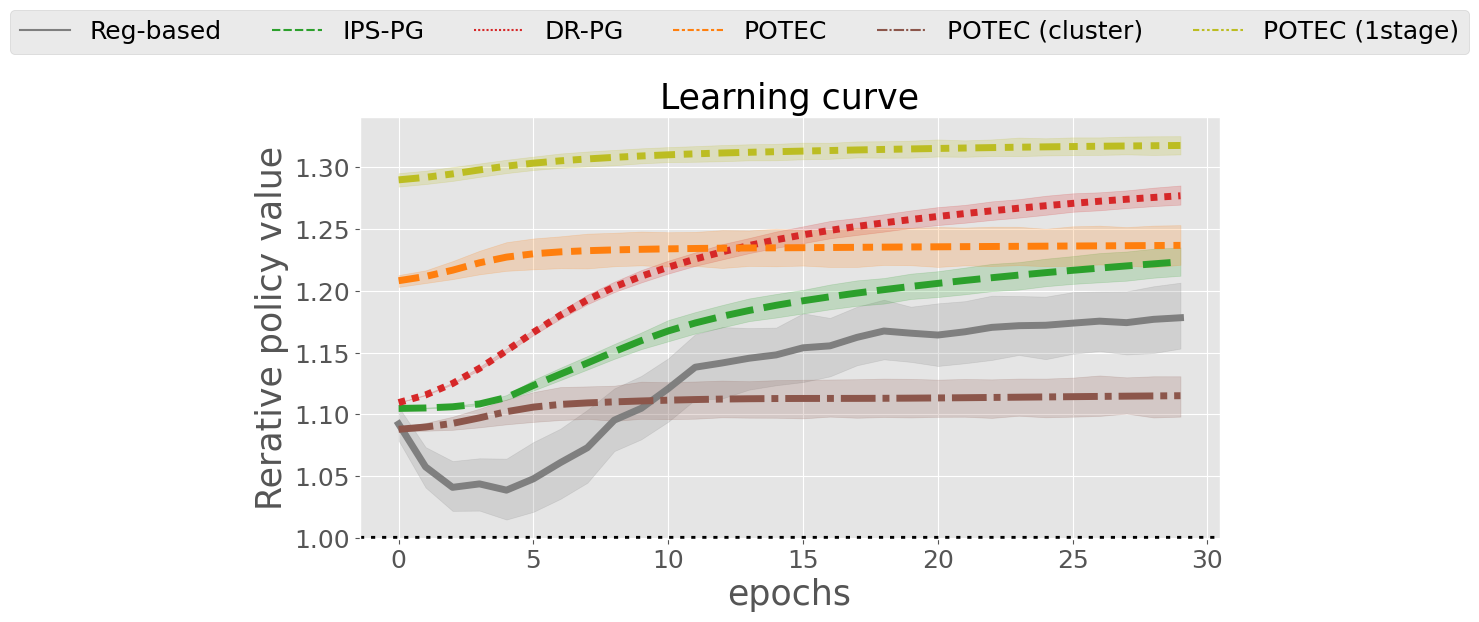

In [5]:
visualize_learning_curve(curve_df)

# Off-policy learning with Two-Tower Model

In [6]:
dataset = SyntheticBanditDatasetWithCluster(
    n_users=n_users,
    dim_context=dim_context,
    n_actions=n_actions,
    n_cat_per_dim=n_cat_per_dim,
    n_cat_dim=n_cat_dim,
    n_clusters=n_clusters,
    beta=beta,
    reward_noise=reward_noise,
    random_state=random_state
)
true_dist_dict = dataset.true_dist_dict
pi_b_a_x = true_dist_dict["pi_0_a_x"]
pi_b_value = dataset.calc_ground_truth_policy_value(pi_b_a_x)

dim_action_context = dataset.action_context_one_hot.shape[1]

curve_df = DataFrame()
for _ in tqdm(range(n_sim)):
    val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
    test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_size)
    
    # Reg-based(simple MLP)
    nn_model = MLP(dim_context=dim_context, dim_output=n_actions, objective="regression", hidden_layer_size=hidden_layer_size)
    mlp = RegBasedPolicyLearner(
        nn_model=nn_model,
        max_iter=max_iter,
        learning_rate_init=0.01,
        batch_size=batch_size,
        ope_estimator=IPS(estimator_name="IPS")
    )
    mlp.fit(val_data, test_data, true_dist_dict=true_dist_dict)
    reg_mlp_ = DataFrame([mlp.test_value, ["Reg-based (simple MLP)"] * max_iter], index=["value", "method"]).T.reset_index()
    
    # Reg-based(Two-Tower Model)
    nn_model = TTM(dim_context=dim_context, dim_action_context=dim_action_context, dim_embed=10, objective="regression", hidden_layer_size=hidden_layer_size)
    ttm = RegBasedPolicyLearner(
        nn_model=nn_model,
        max_iter=max_iter,
        learning_rate_init=0.01,
        batch_size=batch_size,
        ope_estimator=IPS(estimator_name="IPS")
    )
    ttm.fit(val_data, test_data, true_dist_dict=true_dist_dict)
    reg_ttm_ = DataFrame([ttm.test_value, ["Reg-based (Two-Tower)"] * max_iter], index=["value", "method"]).T.reset_index()
    
    # IPS-PG (simple MLP)
    nn_model = MLP(dim_context=dim_context, dim_output=n_actions, objective="decision-making", hidden_layer_size=hidden_layer_size)
    ips = PolicyLearnerOverActionSpaces(
        nn_model=nn_model,
        max_iter=max_iter,
        learning_rate_init=0.01,
        batch_size=batch_size,
        ope_estimator=IPS(estimator_name="IPS")
    )
    ips.fit(val_data, test_data, true_dist_dict=true_dist_dict)
    ips_mlp_ = DataFrame([ips.test_value, ["IPS-PG (simple MLP)"] * max_iter], index=["value", "method"]).T.reset_index()
    
     # IPS-PG (Two-Tower Model)
    nn_model = TTM(dim_context=dim_context, dim_action_context=dim_action_context, dim_embed=10, objective="decision-making", hidden_layer_size=hidden_layer_size)
    ips = PolicyLearnerOverActionSpaces(
        nn_model=nn_model,
        max_iter=max_iter,
        learning_rate_init=0.01,
        batch_size=batch_size,
        ope_estimator=IPS(estimator_name="IPS")
    )
    ips.fit(val_data, test_data, true_dist_dict=true_dist_dict)
    ips_ttm_ = DataFrame([ips.test_value, ["IPS-PG (Two-Tower)"] * max_iter], index=["value", "method"]).T.reset_index()
    
    curve_df = pd.concat([curve_df, pd.concat([reg_mlp_, reg_ttm_, ips_mlp_, ips_ttm_])])

curve_df.reset_index(inplace=True) 
curve_df["pi_b_value"] = pi_b_value
curve_df["rel_value"] = curve_df["value"] / pi_b_value

100% 30/30 [01:59<00:00,  3.99s/it]


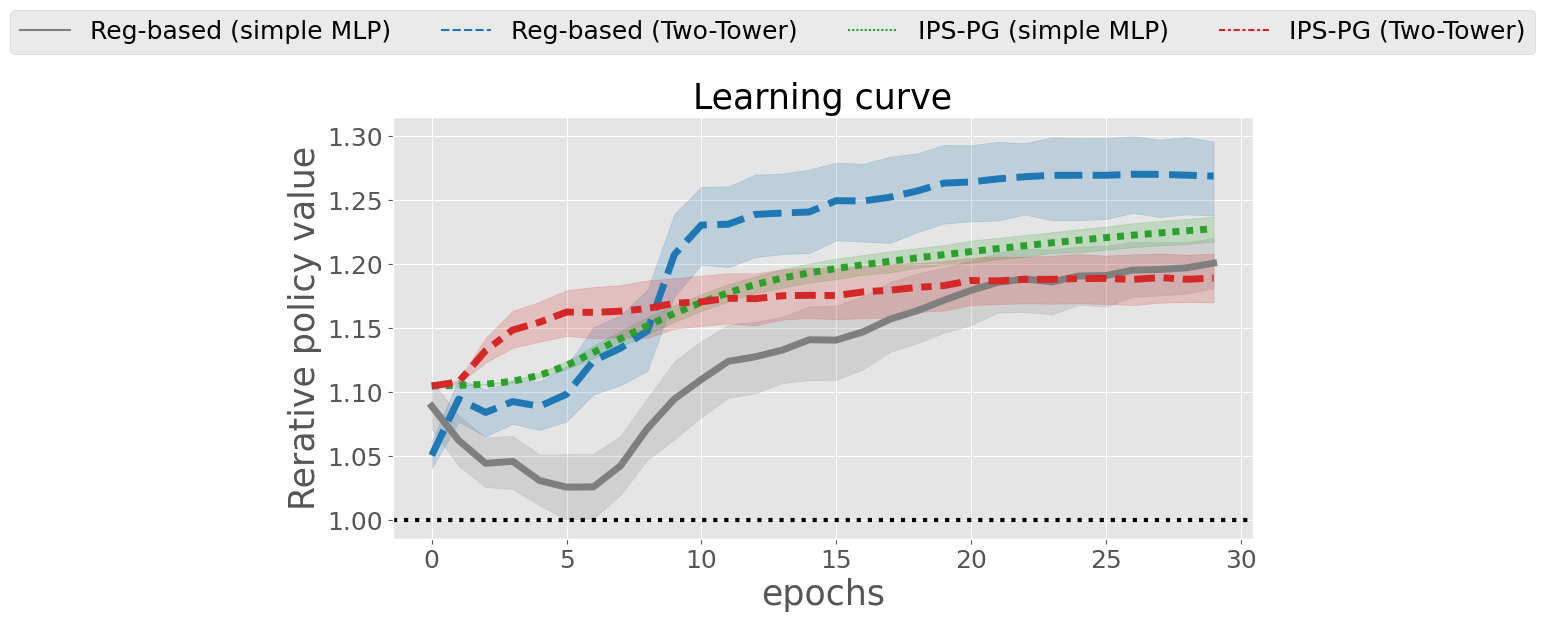

In [7]:
visualize_learning_curve(curve_df)